Python Version: 3.12.4

In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from pathlib import Path


In [121]:
input_file = "../DATA/Sterling.csv"
df = pd.read_csv(input_file)

In [122]:
# Replacing "M" and "T" values with null values
df.replace('M', pd.NA, inplace=True)
df.replace('T', pd.NA, inplace=True)

# Drop annual precipitation
if 'Annual' in df.columns:
    df = df.drop(columns=['Annual'])

# Convert the data to numeric (ignores non-numeric values like NaN)
for month in df.columns[1:]:  # Skip the 'Year' column
    df[month] = pd.to_numeric(df[month], errors='coerce')

df.head()


# Impute missing values
df = df.fillna(method='ffill')
df = df.dropna()

# Calculate the average total percipitation for each month
monthly_avg = df.iloc[:, 1:].mean()

/var/folders/2l/s3vqb85160392xx56h4d2m0c0000gn/T/ipykernel_78335/3999636750.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [123]:

df = pd.melt(df, id_vars=['Year'],
                  var_name='Month',
                  value_name='Value')


# Map the abbreviated month names to numbers (Jan -> 01, Feb -> 02, etc.)
month_map = {'January': '01',
             'February': '02',
             'March': '03',
             'April': '04',
             'May': '05',
             'June': '06',
             'July': '07',
             'August': '08',
             'September': '09',
             'October': '10',
             'November': '11',
             'December': '12'}

# Convert Month abbreviations to numbers and create a Date column
df['Month'] = df['Month'].map(month_map)
df['Date'] = pd.to_datetime(df['Year'].astype(str) + df['Month'], format='%Y%m')


df = df.sort_values("Date")

df.drop(['Month',"Year"], axis=1, inplace=True)
df.set_index('Date', inplace=True)

ADF Statistic: -26.01404438397772
p-value: 0.0


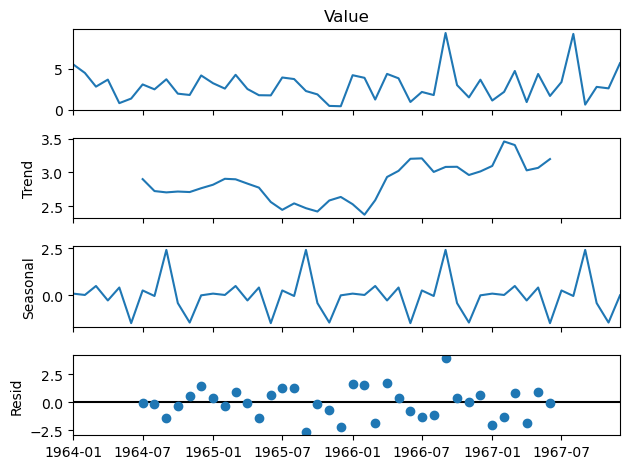

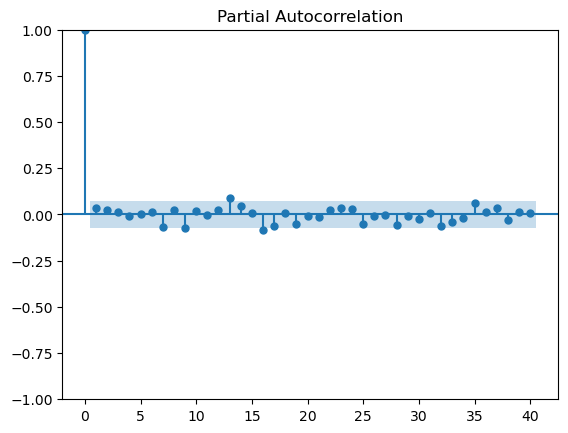

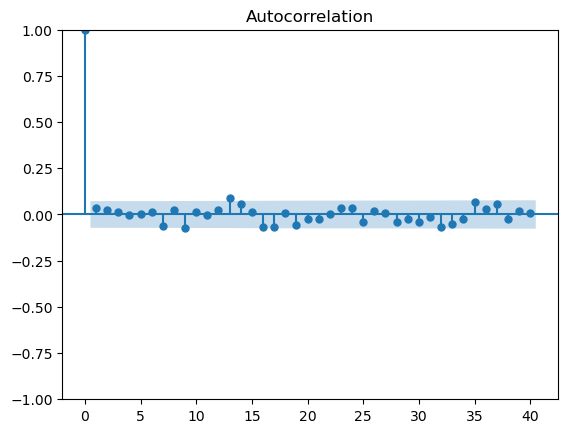

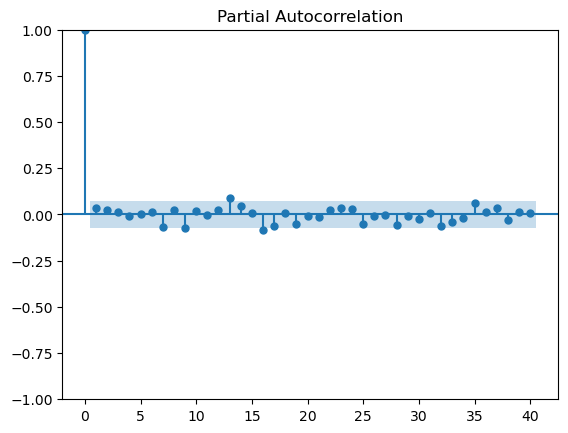

In [124]:
# Check for stationarity using the Augmented Dickey-Fuller test

result = adfuller(df['Value'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

result = seasonal_decompose(df['Value'][:48], model='additive')
result.plot()
plt.show()

plot_acf(df['Value'], lags=40)
plot_pacf(df['Value'], lags=40)

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.34308D+00    |proj g|=  1.22962D-01

At iterate    5    f=  2.16522D+00    |proj g|=  1.47000D-01

At iterate   10    f=  2.12731D+00    |proj g|=  4.75682D-03

At iterate   15    f=  2.12315D+00    |proj g|=  5.20723D-03

At iterate   20    f=  2.12270D+00    |proj g|=  9.81201D-04

At iterate   25    f=  2.12265D+00    |proj g|=  8.62228D-04

At iterate   30    f=  2.12265D+00    |proj g|=  3.41464D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/var/folders/2l/s3vqb85160392xx56h4d2m0c0000gn/T/ipykernel_78335/1021959036.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  forecast_index = pd.date_range(start=df.index[-4] + pd.DateOffset(months=1), periods=12, freq='M')


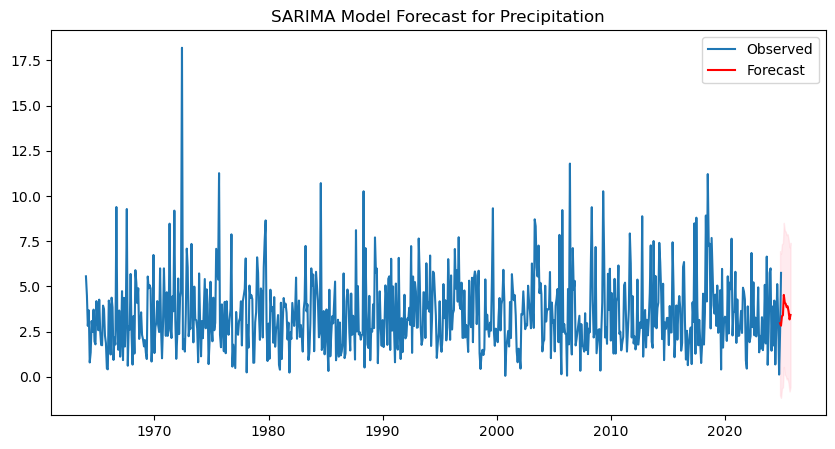

In [125]:
model = SARIMAX(df['Value'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fit = model.fit()

# Forecast the next 12 months
forecast = sarima_fit.get_forecast(steps=12)
forecast_index = pd.date_range(start=df.index[-4] + pd.DateOffset(months=1), periods=12, freq='M')
forecast_values = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(10, 5))
plt.plot(df, label='Observed')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("SARIMA Model Forecast for Precipitation")
plt.legend()
plt.show()

In [126]:
forecast_df = pd.DataFrame({'Date': forecast_index, 'Precipitation': forecast_values})
forecast_df.set_index('Date', inplace=True)
forecast_df.index = forecast_df.index.strftime('%m-%Y')

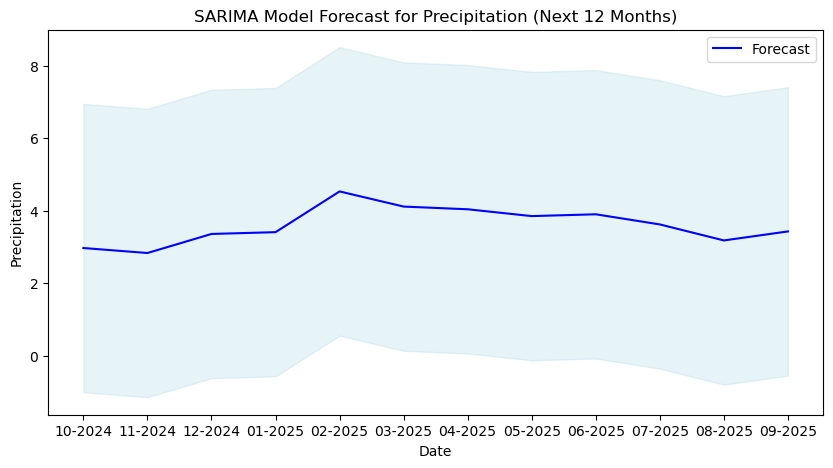

In [127]:
# Plot only the forecast
plt.figure(figsize=(10, 5))
plt.plot(forecast_df.index, forecast_df['Precipitation'], label='Forecast', color='blue')

# Optionally, you can fill the confidence intervals for a clearer visualization
plt.fill_between(forecast_df.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1],
                 color='lightblue', alpha=0.3)

# Customize the plot
plt.title("SARIMA Model Forecast for Precipitation (Next 12 Months)")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.legend()
plt.show()

In [ ]:
output_dir = Path("../OUTPUT")
output_dir.mkdir(parents=True, exist_ok=True)  # Create the directory if it doesn't exist

# Create the output filename with the "output" suffix
input_path = Path(input_file)
output_file = output_dir / f"{input_path.stem}_output{input_path.suffix}"

# Save the DataFrame to the new output filename
forecast_df.to_csv(output_file, index=True)
print(f"File saved as: {output_file}")

File saved as: ../OUTPUT/Sterling_output.csv
